<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [58]:
#!pip install orbit-ml
#!pip install prophet
#!pip install sktime[all_extras]

In [59]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# my addings
import seaborn as sns

## Задание 1 (2 балла). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекоммендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



In [60]:
# скачаем данные из рекоммендованной статьи https://github.com/rishabh89007/Time_Series_Datasets
!wget https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/main/HH%20Spot%20Price.csv # месячная частота
!wget https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/main/Nuclear%20Capacity.csv  # дневная частота

# данные принадлежат https://www.eia.gov

--2021-06-13 18:43:45--  https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/main/HH%20Spot%20Price.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4420 (4.3K) [text/plain]
Saving to: ‘HH Spot Price.csv.2’

HH Spot Price.csv.2 100%[===================>]   4.32K  --.-KB/s    in 0s      

2021-06-13 18:43:46 (39.7 MB/s) - ‘HH Spot Price.csv.2’ saved [4420/4420]

--2021-06-13 18:43:46--  https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/main/Nuclear%20Capacity.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response...

In [61]:
# считаем файлы
ts1_m = pd.read_csv("/content/HH Spot Price.csv")
ts2_d = pd.read_csv("/content/Nuclear Capacity.csv")

In [62]:
ts1_m.head()

,Unnamed: 0,"Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu)"
0,1997 01,3.45
1,1997 02,2.15
2,1997 03,1.89
3,1997 04,2.03
4,1997 05,2.25


In [63]:
ts2_d.head(10)

,Unnamed: 0,"U.S. nuclear capacity, daily (Megawatts)"
0,2007 0101 01,101764.9
1,2007 0102 02,101764.9
2,2007 0103 03,101764.9
3,2007 0104 04,101764.9
4,2007 0105 05,101764.9
5,2007 0106 06,101764.9
6,2007 0107 07,101764.9
7,2007 0108 08,101764.9
8,2007 0109 09,101764.9
9,2007 0110 10,101764.9


In [64]:
ts1_m.columns = ['date', 'price']
# Отсортируем и добавим date в индекс
ts1_m = ts1_m.sort_values(by = "date")
ts1_m.index = pd.PeriodIndex(ts1_m.date, freq='M')
#ts1_m.drop("date", axis=1, inplace=True)
ts1_m.head()

,date,price
date,,
1997-01,1997 01,3.45
1997-02,1997 02,2.15
1997-03,1997 03,1.89
1997-04,1997 04,2.03
1997-05,1997 05,2.25


In [65]:
ts2_d.columns = ['date', 'megawatts']
# Отсортируем и добавим date в индекс
ts2_d = ts2_d.sort_values(by = "date")
ts2_d.date = ts2_d.date.str.split()
ts2_d.date = [''.join(line[:2]) for line in ts2_d.date]
ts2_d.date = pd.to_datetime(ts2_d.date, format='%Y%M%D',  errors='ignore')
ts2_d.index = pd.PeriodIndex(ts2_d.date, freq='D')
#ts2_d.drop("date", axis=1, inplace=True)
ts2_d.head()

,date,megawatts
date,,
2007-01-01,20070101,101764.9
2007-01-02,20070102,101764.9
2007-01-03,20070103,101764.9
2007-01-04,20070104,101764.9
2007-01-05,20070105,101764.9


In [66]:
# сделаем разбиение на train/test
#ts1_m.shape, ts2_d.shape
ts1_m.shape[0] * 0.8, ts2_d.shape[0]*0.8

(232.8, 4180.0)

In [67]:
ts1_m_train = ts1_m[:233]
ts1_m_test = ts1_m[233:]
ts2_d_train = ts2_d[:4180]
ts2_d_test = ts2_d[4180:]

In [68]:
ts1_m_train.shape, ts1_m_test.shape, ts2_d_train.shape, ts2_d_test.shape # тесте больше двух лет: 58/12 = 4  года 10 мес, 1045/365 =~ 2.86 года

((233, 2), (58, 2), (4180, 2), (1045, 2))

In [69]:
ts1_m_train

,date,price
date,,
1997-01,1997 01,3.45
1997-02,1997 02,2.15
1997-03,1997 03,1.89
1997-04,1997 04,2.03
1997-05,1997 05,2.25
...,...,...
2016-01,2016 01,2.28
2016-02,2016 02,1.99
2016-03,2016 03,1.73


## Задание 2. Анализ временных рядов (1 балла).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики автокорреляционных функций для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

In [70]:
ts2_d_train

,date,megawatts
date,,
2007-01-01,20070101,101764.9
2007-01-02,20070102,101764.9
2007-01-03,20070103,101764.9
2007-01-04,20070104,101764.9
2007-01-05,20070105,101764.9
...,...,...
2018-06-07,20180607,99730.6
2018-06-08,20180608,99730.6
2018-06-09,20180609,99730.6


In [71]:
#ts1_m_train.index, ts1_m_train.price

<AxesSubplot:xlabel='date'>

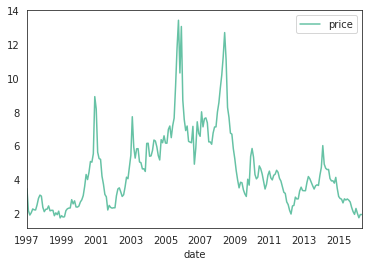

In [72]:
ts1_m_train.plot()

In [73]:
# setting up seaborn configuration
sns.set_style("white")
sns.set_palette(sns.color_palette("Set2"))
plt.rcParams["figure.figsize"] = (16,8)

In [74]:
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


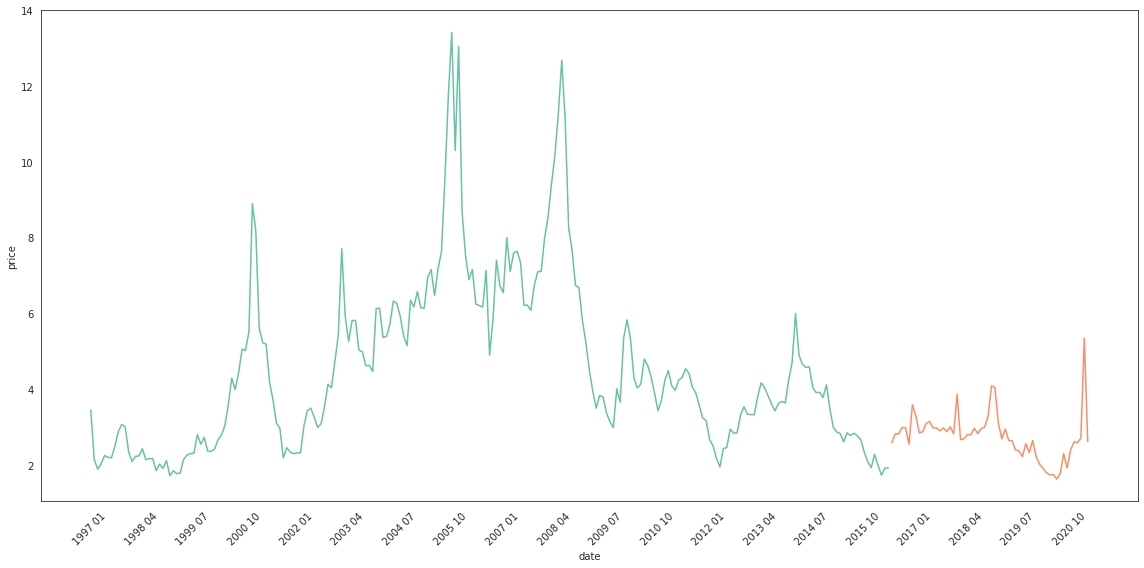

In [75]:
# отрисуем временные ряды
# месячные данные
#pd.plotting.register_matplotlib_converters() #
from matplotlib.ticker import MaxNLocator
fig,axes=plt.subplots(1,1)
sns.lineplot(x=ts1_m_train['date'], y=ts1_m_train['price'], data=ts1_m_train)
sns.lineplot(x=ts1_m_test['date'], y=ts1_m_test['price'], data=ts1_m_test)
axes.xaxis.set_major_locator(MaxNLocator(31))
plt.xticks(rotation=45)
plt.tight_layout()
#plt.title('seaborn-matplotlib example')
# To specify the number of ticks on both or any single axes
#plt.xaxis.set_major_locator(plt.MaxNLocator(3))

<AxesSubplot:ylabel='Frequency'>

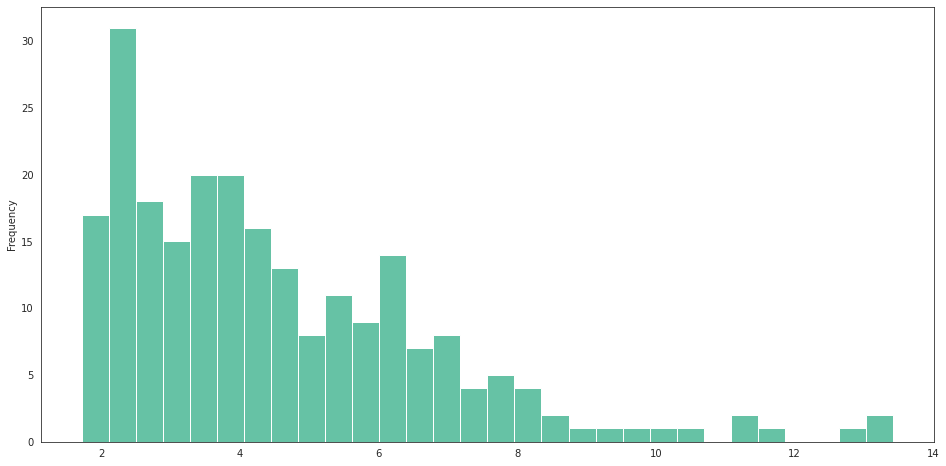

In [76]:
# можно добавить гистограмму -- будет перекошенная
ts1_m_train['price'].plot(kind = "hist", bins = 30)

Дисперсия непостоянная, распределение с асимметрией вправо -- прологарифмируем ряд, чтобы стабилизирвать дисперсию. Запомним, что для построения предсказаний нужно взять экспоненту.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


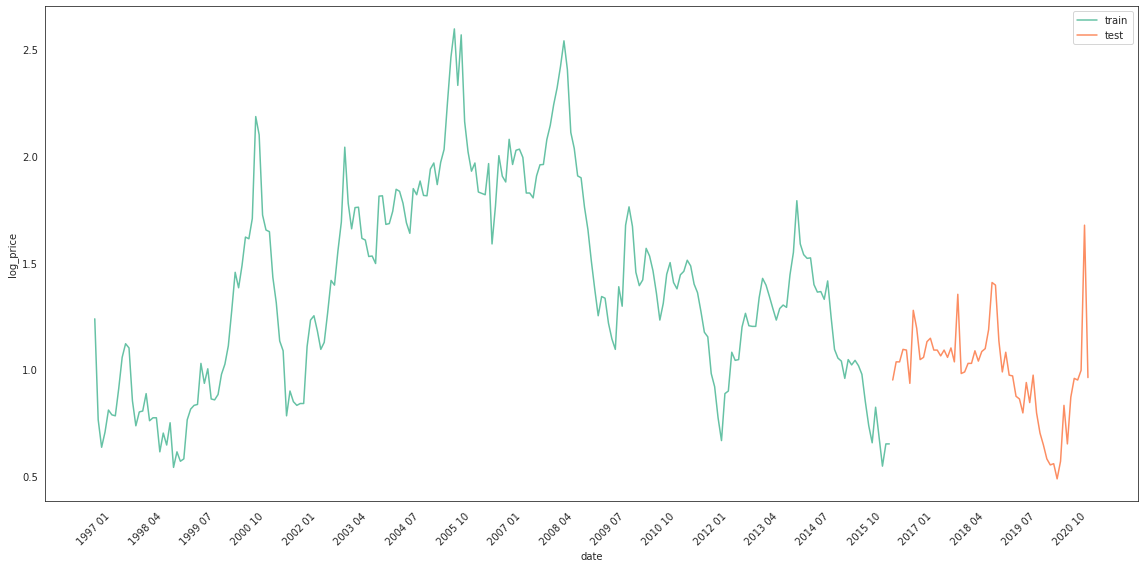

In [77]:
fig,axes=plt.subplots(1,1)
ts1_m_train['log_price'] = np.log(ts1_m_train['price'])
# ts1_m_test['log_price'] = np.log(ts1_m_test['price']) # тест мы не меняем, но хотим посмотреть на график
sns.lineplot(x=ts1_m_train['date'], y=ts1_m_train['log_price'], data=ts1_m_train, )
sns.lineplot(x=ts1_m_test['date'], y=np.log(ts1_m_test['price']), data=ts1_m_test)
axes.xaxis.set_major_locator(MaxNLocator(31))
plt.xticks(rotation=45)
axes.legend(['train', 'test'])
plt.tight_layout()

<AxesSubplot:ylabel='Frequency'>

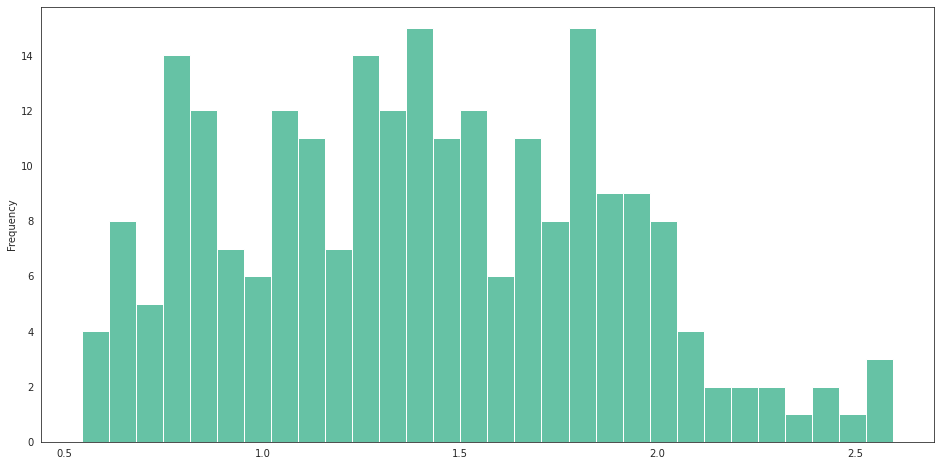

In [78]:
ts1_m_train['log_price'].plot(kind = "hist", bins = 30)

Дисперсия стабилизировалась. Распределение выровнялось.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


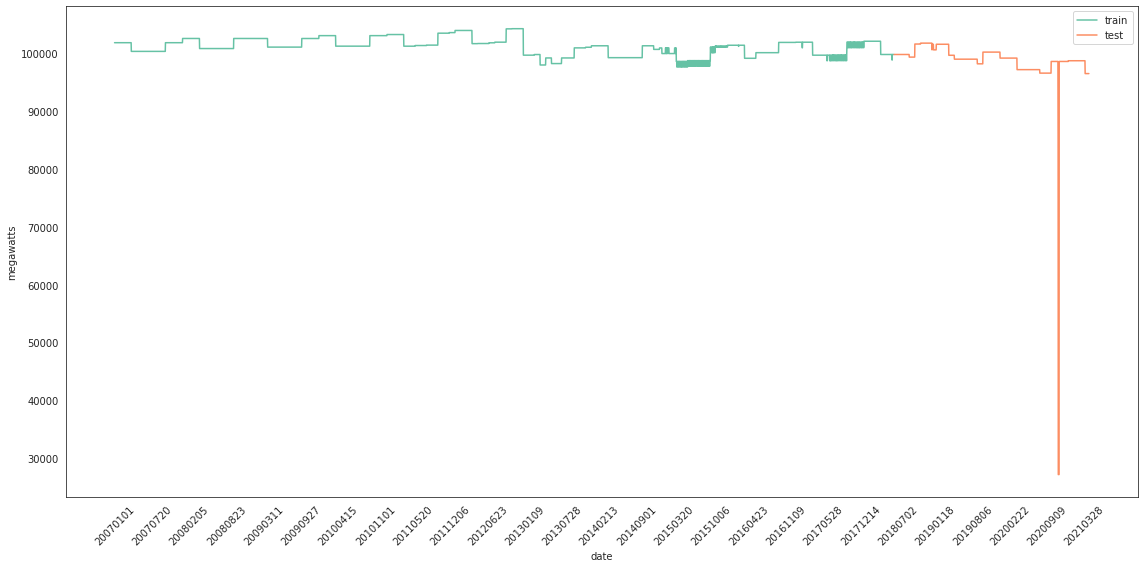

In [79]:
# дневные данные
fig,axes=plt.subplots(1,1)
sns.lineplot(x=ts2_d_train['date'], y=ts2_d_train['megawatts'], data=ts2_d_train)
sns.lineplot(x=ts2_d_test['date'], y=ts2_d_test['megawatts'], data=ts2_d_test)
axes.xaxis.set_major_locator(MaxNLocator(31))
plt.xticks(rotation=45)
axes.legend(['train', 'test'])
plt.tight_layout()

<AxesSubplot:ylabel='Frequency'>

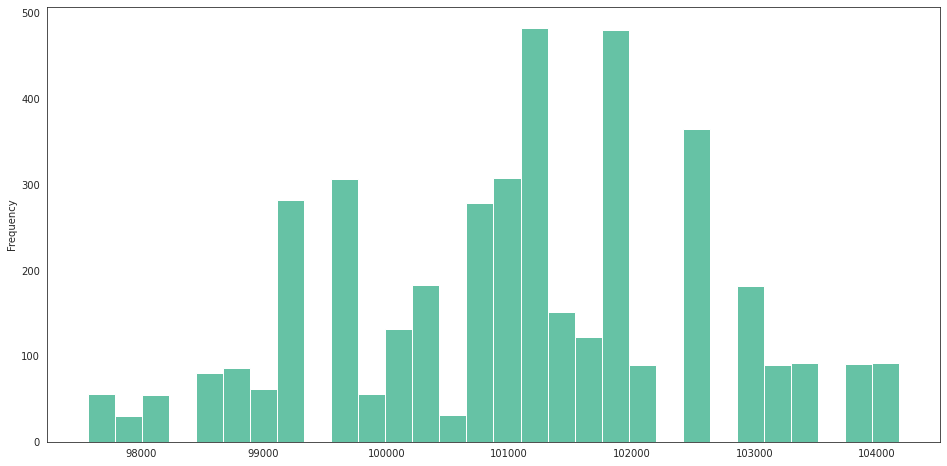

In [80]:
# уже похоже на нормальное распределение, не будем логарифмировать
ts2_d_train['megawatts'].plot(kind = "hist", bins = 30)

Логарифмировать нет смысла, дисперия стабильная.

Начнем с данных с мясячной частотой: спот-цена газа в газораспределительном центре Henry Hub в США, долларов за миллион британских термальных единиц

In [81]:
# посчитаем адекватный данным максимальный лаг
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html
# для больших лагов рассчеты будут не корректны (мб корреляция >1 из-за особенностей алгоритма +
# требутеся стационарность ряда

min(int(10 * np.log10(ts1_m_train.shape[0])), ts1_m_train.shape[0] // 2 - 1)

23

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


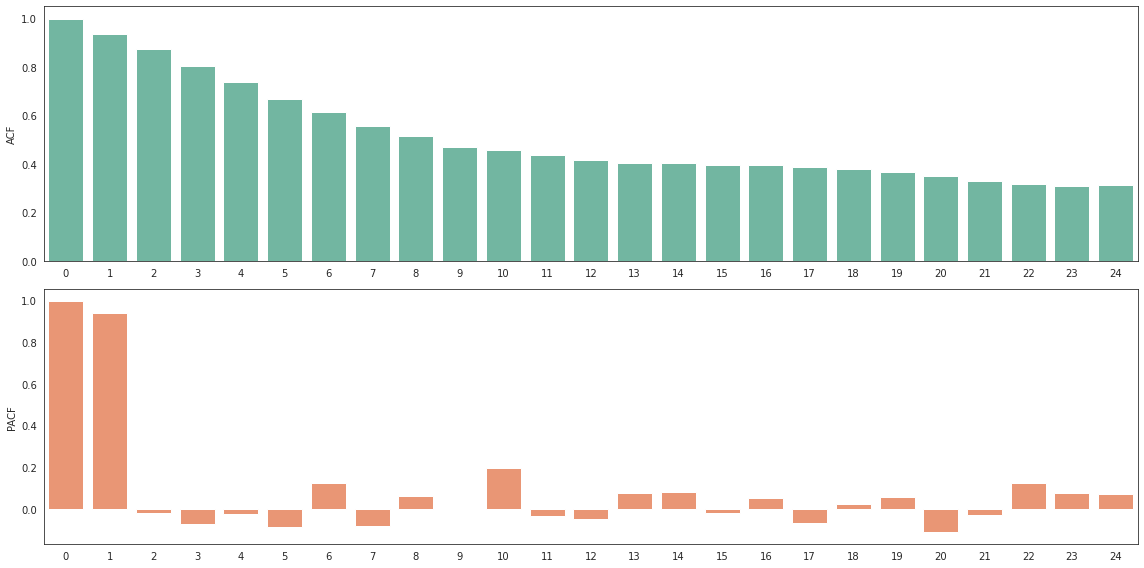

In [82]:
# ACF и PACF
from statsmodels.tsa.stattools import acf, pacf
#pacf = pacf(ts2_d_train.megawatts, nlags=23)
#pd.Series(pacf).plot(kind = "bar")

acf_1m = acf(ts1_m_train.price, nlags=24)
pacf_1m = pacf(ts1_m_train.price, nlags=24)
fig, axes=plt.subplots(2, 1) #(2,1)
sns.barplot(x=pd.Series(acf_1m).index, y=pd.Series(acf_1m).values, ax=axes[0], ci='sd', errcolor='red', errwidth=3.0, n_boot=20, color=sns.color_palette("Set2")[0])
sns.barplot(x=pd.Series(pacf_1m).index, y=pd.Series(pacf_1m).values, ax=axes[1], color=sns.color_palette("Set2")[1])
axes[0].set_ylabel('ACF')
#axes[1].set_title('PACF')
axes[1].set_ylabel('PACF')
#plt.xticks(rotation=45)
plt.tight_layout()

Отметим, что частный коэффициент корреляции первого лага велик, что говорит о наличии тренда.

In [83]:
np.argmax(abs(pacf_1m[1:])), np.argmax(pacf_1m[1:]) # первый лаг

(0, 0)

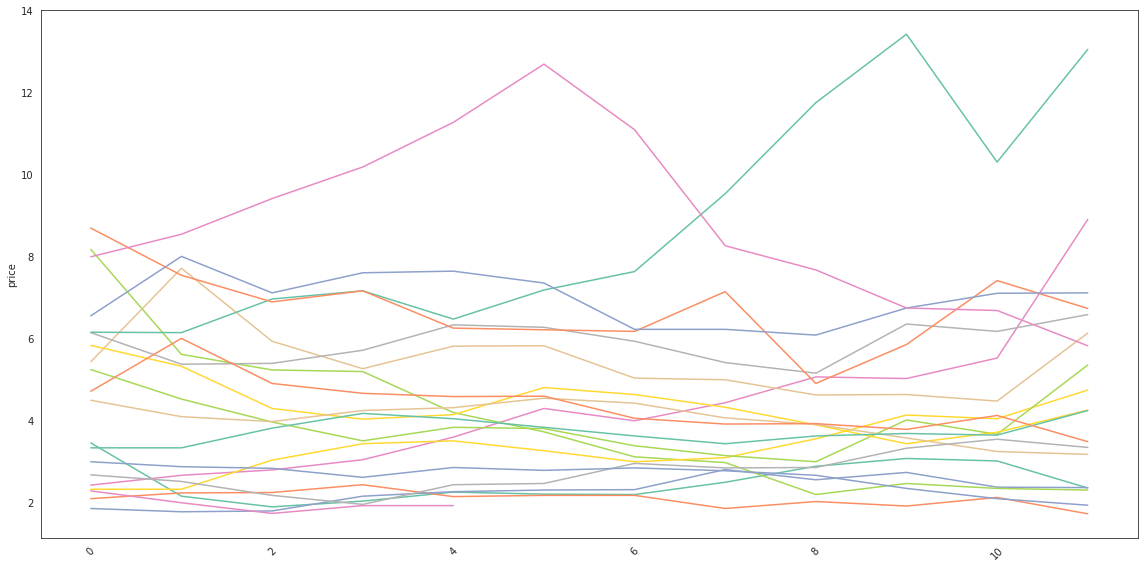

In [84]:
# отрисуем наложенные временные ряды
# месячная сезонность
seas = 12
import math
l = math.ceil(ts1_m_train.shape[0] / seas)
fig,axes=plt.subplots(1,1)
for i in range(l):
  sns.lineplot(x=np.arange(len(ts1_m_train['price'][seas*i:seas*i+seas])), y=ts1_m_train['price'][seas*i:seas*i+seas], data=ts1_m_train[seas*i:seas*i+seas])
plt.xticks(rotation=45)
plt.tight_layout()


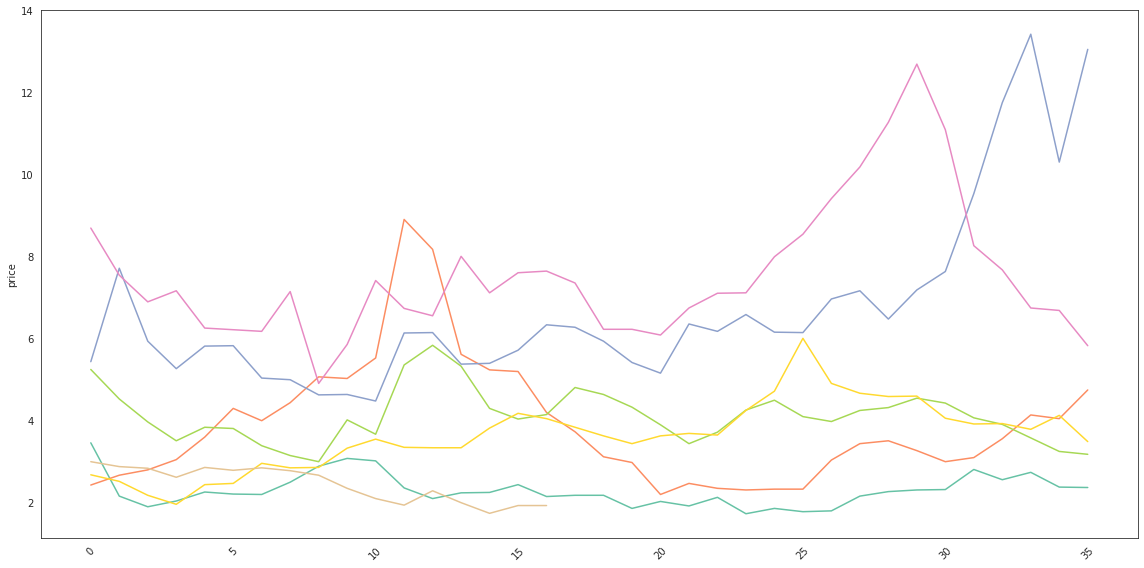

In [85]:
seas = 36
l = math.ceil(ts1_m_train.shape[0] / seas)
fig,axes=plt.subplots(1,1)
for i in range(l):
  sns.lineplot(x=np.arange(len(ts1_m_train['price'][seas*i:seas*i+seas])), y=ts1_m_train['price'][seas*i:seas*i+seas], data=ts1_m_train[seas*i:seas*i+seas])
plt.xticks(rotation=45)
plt.tight_layout()

Отметим, что визуально лаг в 3 года имеет смысл. Скорее это не сезонность, а цикличность спроса на газ. Но для всего ряда нет высокой корреляции на уровне лагов 12,24 или 36, т.е. нет логичной годовой интерпретации.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


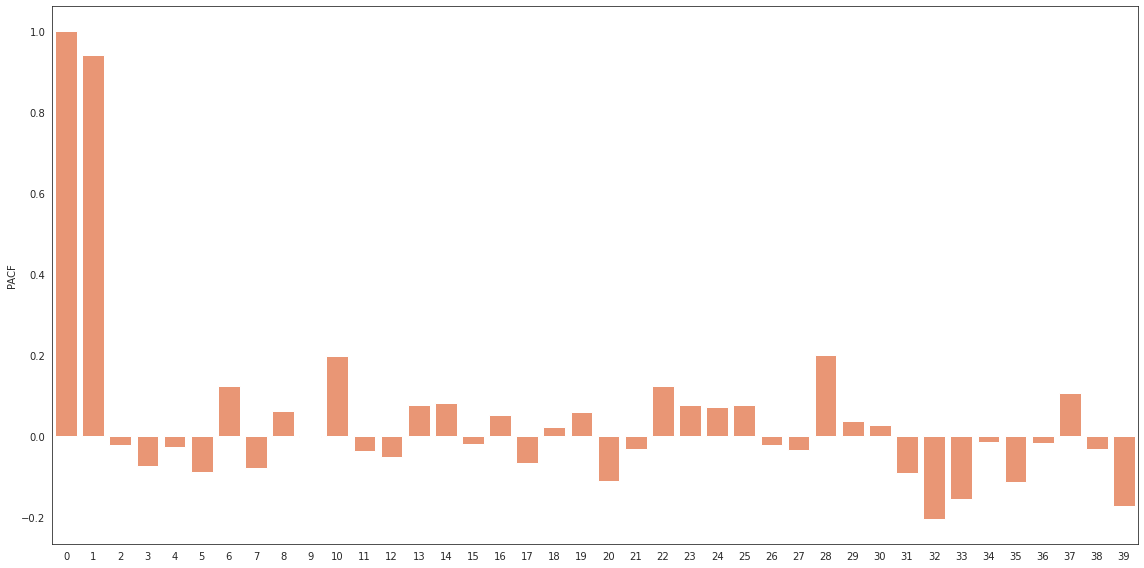

In [86]:

pacf_1m = pacf(ts1_m_train.price, nlags=115)
fig, axes=plt.subplots(1, 1) #(2,1)
sns.barplot(x=pd.Series(pacf_1m).index[:40], y=pd.Series(pacf_1m).values[:40], ax=axes, color=sns.color_palette("Set2")[1])
axes.set_ylabel('PACF')
plt.tight_layout()

Переходим к анализу рядов с дневной периодичностью: вырабатываемые яедерные мощости в США, мегаватты

In [87]:
min(int(10 * np.log10(ts2_d_train.shape[0])), ts2_d_train.shape[0] // 2 - 1)

36

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


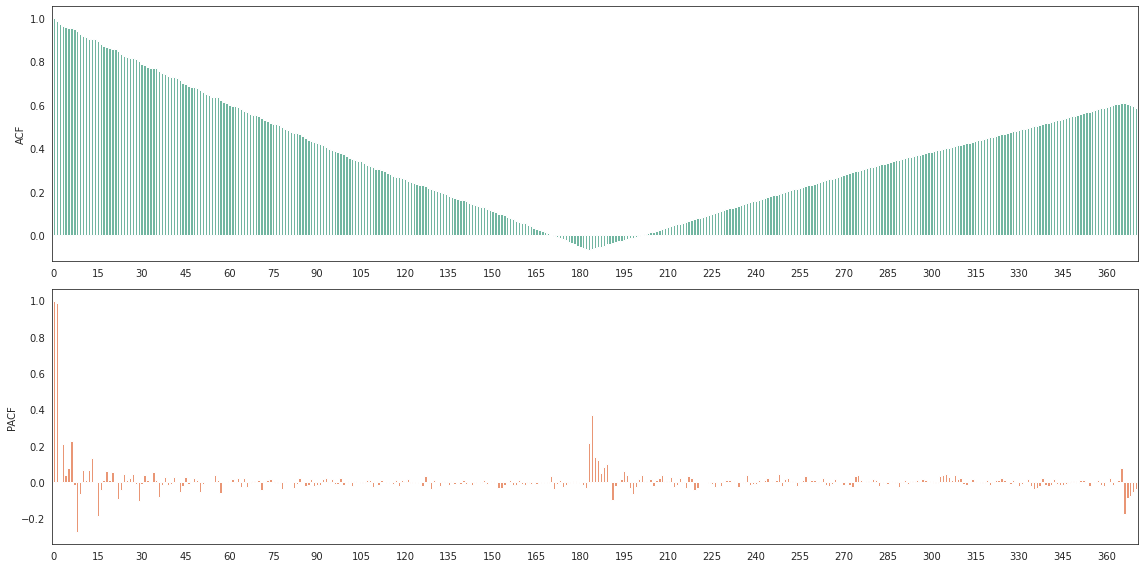

In [88]:
acf_2d = acf(ts2_d_train.megawatts, nlags=370)
pacf_2d = pacf(ts2_d_train.megawatts, nlags=370)
fig, axes=plt.subplots(2, 1) #(2,1)
sns.barplot(x=pd.Series(acf_2d).index, y=pd.Series(acf_2d).values, ax=axes[0], ci='sd', errcolor='red', errwidth=3.0, n_boot=20, color=sns.color_palette("Set2")[0])
sns.barplot(x=pd.Series(pacf_2d).index, y=pd.Series(pacf_2d).values, ax=axes[1], color=sns.color_palette("Set2")[1])
axes[0].set_ylabel('ACF')
axes[1].set_ylabel('PACF')
axes[0].xaxis.set_major_locator(MaxNLocator(31))
axes[1].xaxis.set_major_locator(MaxNLocator(31))
plt.tight_layout()

Отметим, во-первых, годовую сезонность: АКФ достигает макимума на 365-й лаг. Во-вторых, на ЧАКФ есть значительная корреляция посреди года.

In [89]:
np.argmax(pacf_2d[20:]) # похоже на полугодовую сезонность

164

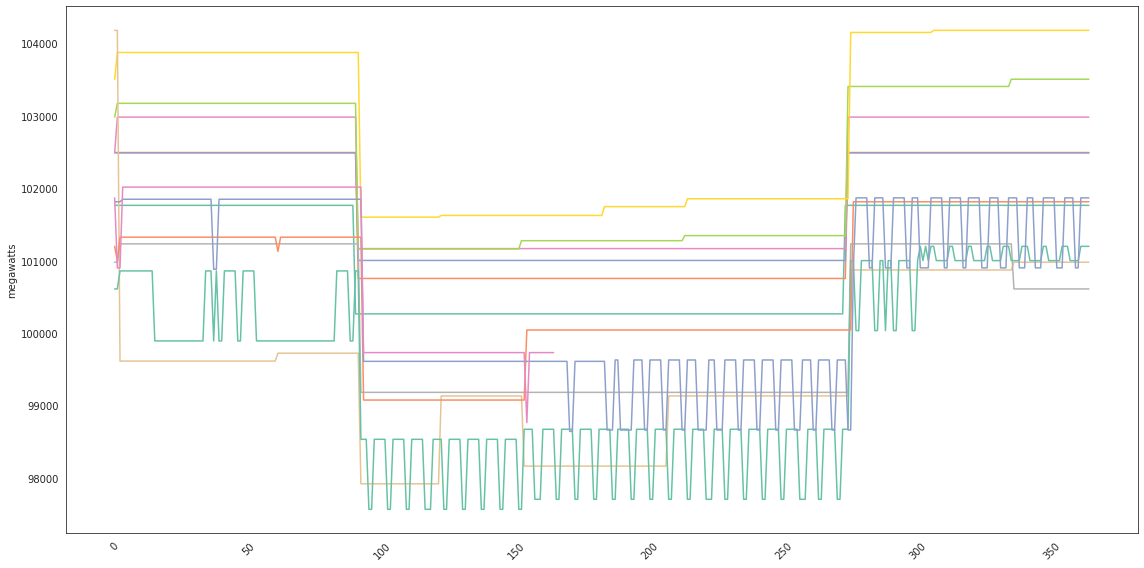

In [90]:
# отрисуем наложенные временные ряды
# годовая сезонность
seas = 365
import math
l = math.ceil(ts2_d_train.shape[0] / seas)
fig,axes=plt.subplots(1,1)
for i in range(l):
  sns.lineplot(x=np.arange(len(ts2_d_train['megawatts'][seas*i:seas*i+seas])), y=ts2_d_train['megawatts'][seas*i:seas*i+seas], data=ts2_d_train[seas*i:seas*i+seas])
plt.xticks(rotation=45)
plt.tight_layout()

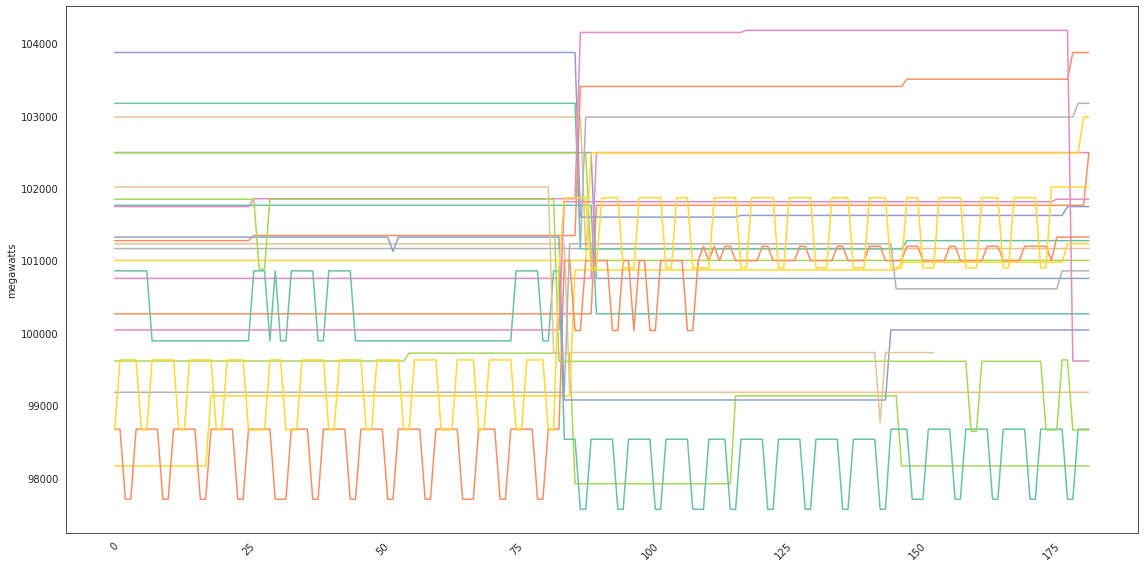

In [91]:
# отрисуем наложенные временные ряды
# полугодовая сезонность
seas = 183 # как раз полгода
import math
l = math.ceil(ts2_d_train.shape[0] / seas)
fig,axes=plt.subplots(1,1)
for i in range(l):
  sns.lineplot(x=np.arange(len(ts2_d_train['megawatts'][seas*i:seas*i+seas])), y=ts2_d_train['megawatts'][seas*i:seas*i+seas], data=ts2_d_train[seas*i:seas*i+seas])
#sns.lineplot(x=ts1_m_test['date'], y=ts1_m_test['price'], data=ts1_m_test)
#axes.xaxis.set_major_locator(MaxNLocator(31))
plt.xticks(rotation=45)
plt.tight_layout()

Среди года половина рядов далают скачок вврех, а половина вниз, то есть высокая частная корреляция среди года объеснялась корреляция первых и вторых полугодний по отдельности. Остановимся на годовой сезонности.

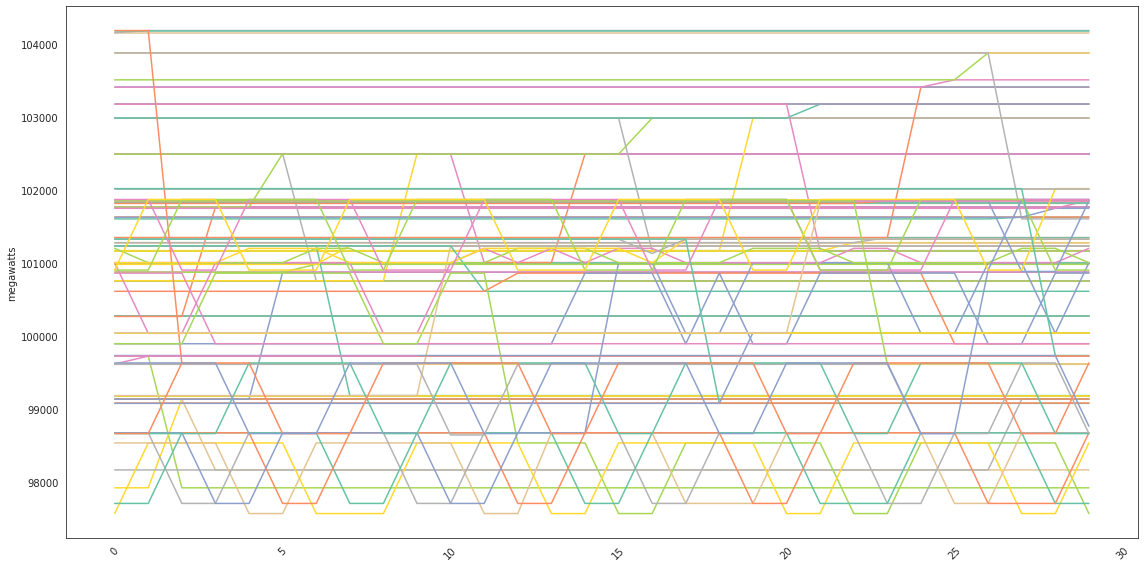

In [92]:
seas = 30 # месячная сезонность не складывается
import math
l = math.ceil(ts2_d_train.shape[0] / seas)
fig,axes=plt.subplots(1,1)
for i in range(l):
  sns.lineplot(x=np.arange(len(ts2_d_train['megawatts'][seas*i:seas*i+seas])), y=ts2_d_train['megawatts'][seas*i:seas*i+seas], data=ts2_d_train[seas*i:seas*i+seas])
plt.xticks(rotation=45)
plt.tight_layout()

In [93]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными

## Задание 3. Предсказание месячного временного ряда (4.5 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.


### NaiveForecaster из sktime (0.5 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

Т.к. для месячного ряда сезонная компонента = 0, второй способ реализуем для дневого, хотя в задании просят для месячного, чтобы посмотреть, как работает способ.

In [94]:
from sktime.forecasting.naive import NaiveForecaster

# ваш код обучения моделей здесь

# https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.naive.NaiveForecaster.html
#https://www.sktime.org/en/latest/examples/01_forecasting.html
from sktime.forecasting.base import ForecastingHorizon
fh1 = np.arange(ts1_m_test.shape[0]) + 1
fh2 = np.arange(ts2_d_test.shape[0]) + 1

last_pred_1m = NaiveForecaster(strategy="last").fit(ts1_m_train['log_price']).predict(fh1)
last_pred_2d = NaiveForecaster(strategy="last").fit(ts2_d_train['megawatts']).predict(fh2)

In [95]:
fh1, ts1_m_test.shape[0]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58]), 58)

In [96]:
np.array(ts1_m_test['price'])

array([2.59, 2.82, 2.82, 2.99, 2.98, 2.55, 3.59, 3.3 , 2.85, 2.88, 3.1 ,
       3.15, 2.98, 2.98, 2.9 , 2.98, 2.88, 3.01, 2.82, 3.87, 2.67, 2.69,
       2.8 , 2.8 , 2.97, 2.83, 2.96, 3.  , 3.28, 4.09, 4.04, 3.11, 2.69,
       2.95, 2.65, 2.64, 2.4 , 2.37, 2.22, 2.56, 2.33, 2.65, 2.22, 2.02,
       1.91, 1.79, 1.74, 1.75, 1.63, 1.77, 2.3 , 1.92, 2.39, 2.61, 2.59,
       2.71, 5.35, 2.62])

In [97]:
last_pred_1m[:10]

2016-06    0.652325
2016-07    0.652325
2016-08    0.652325
2016-09    0.652325
2016-10    0.652325
2016-11    0.652325
2016-12    0.652325
2017-01    0.652325
2017-02    0.652325
2017-03    0.652325
Freq: M, dtype: float64

In [98]:
# посчитайте метрики на test
from statsmodels.tools.eval_measures import meanabs
mae_last_pred_1m = meanabs(np.exp(last_pred_1m), ts1_m_test['price'])
mae_last_pred_2d = meanabs(last_pred_2d, ts2_d_test['megawatts'])
results = pd.DataFrame(columns = ["Frequency", "Model", "Forecast", "MAE"])

#for i, freq in enumerate("Monthly", "Daily")

results.loc[0,"Frequency"] = "Monthly"
results.loc[0,"Model"] = "Last"
results.loc[0,"Forecast"] = np.exp(last_pred_1m[0])
results.loc[0,"MAE"] = mae_last_pred_1m

results.loc[1,"Frequency"] = "Daily"
results.loc[1,"Model"] = "Last"
results.loc[1,"Forecast"] = last_pred_2d[0]
results.loc[1,"MAE"] = mae_last_pred_2d

results

,Frequency,Model,Forecast,MAE
0,Monthly,Last,1.92,0.871724
1,Daily,Last,99730.6,1665.97


In [99]:
results[results.Frequency == 'Daily']

,Frequency,Model,Forecast,MAE
1,Daily,Last,99730.6,1665.97


In [100]:
# второй наивный способ с предсказанием из предыдущего сезона, а не последнего значения

prev_pred_1m = NaiveForecaster(strategy="last", sp=12).fit(ts1_m_train['price']).predict(fh1)
prev_pred_2d = NaiveForecaster(strategy="last", sp=365).fit(ts2_d_train['megawatts']).predict(fh2)
mae_prev_pred_1m = meanabs(np.exp(prev_pred_1m), ts1_m_test['price'])
mae_prev_pred_2d = meanabs(prev_pred_2d, ts2_d_test['megawatts'])


results.loc[2,"Frequency"] = "Monthly"
results.loc[2,"Model"] = "Previous"
results.loc[2,"Forecast"] = "Previous Month"
results.loc[2,"MAE"] = mae_prev_pred_1m


results.loc[3,"Frequency"] = "Daily"
results.loc[3,"Model"] = "Previous"
results.loc[3,"Forecast"] = "That day year back"
results.loc[3,"MAE"] = mae_prev_pred_2d
results

,Frequency,Model,Forecast,MAE
0,Monthly,Last,1.92,0.871724
1,Daily,Last,99730.6,1665.97
2,Monthly,Previous,Previous Month,7.79998
3,Daily,Previous,That day year back,2043.12


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


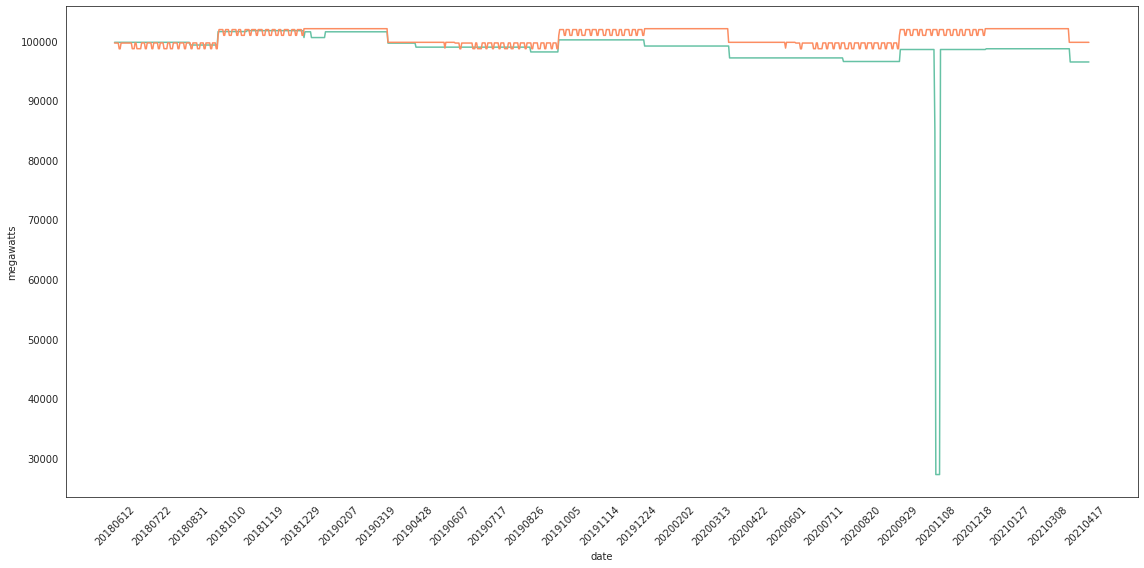

In [101]:
# дневные данные # вообще просто наивный прогноз уже хорошо в плане точной динамики
fig,axes=plt.subplots(1,1)
sns.lineplot(x=ts2_d_test['date'], y=ts2_d_test['megawatts'], data=ts2_d_test)
sns.lineplot(x=ts2_d_test['date'], y=prev_pred_2d, data=prev_pred_2d)
axes.xaxis.set_major_locator(MaxNLocator(31))
plt.xticks(rotation=45)
plt.tight_layout()

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

In [102]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

# ваш код обучения моделей здесь

# https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.ARIMA.html
sarima = ARIMA(
  order=(1, 1, 1),
  seasonal_order=(1, 0, 0, 12),
  suppress_warnings=True)

sarima_pred_1m = sarima.fit(ts1_m_train['log_price']).predict(fh1)

In [103]:
# поменяем формат для AutoARIMA # вообще с моими индексами с месячной частотой и так работало в прежнем формате

ts1_m_train_series = pd.Series(data=ts1_m_train['log_price'].values, index=ts1_m_train['date'].index)
ts1_m_test_series = pd.Series(data=ts1_m_test['price'].values, index=ts1_m_test['date'].index)

ts1_m_train_series.head() # нужный формат

date
1997-01    1.238374
1997-02    0.765468
1997-03    0.636577
1997-04    0.708036
1997-05    0.810930
Freq: M, dtype: float64

In [104]:
ts1_m_test_series.head() # нужный формат

date
2016-06    2.59
2016-07    2.82
2016-08    2.82
2016-09    2.99
2016-10    2.98
Freq: M, dtype: float64

In [105]:
fh1_series = ForecastingHorizon(ts1_m_test_series.index, is_relative=False)

autosarima = AutoARIMA(start_p=1, d=None, start_q=0, 
                       max_p=2, max_d=1, max_q=0, 
                       start_P=1, D=1, start_Q=0, 
                       max_P=1, max_D=1, max_Q=0, 
                       sp=12, suppress_warnings=True, stepwise=False, n_jobs=-1)

autosarima_pred_1m = autosarima.fit(ts1_m_train_series).predict(fh1_series)

In [106]:
autosarima_pred_1m, conf_int = autosarima.fit(ts1_m_train_series).predict(fh1_series, return_pred_int=True)

In [107]:
conf_int # работает

,lower,upper
2016-06,0.368086,1.001687
2016-07,0.217433,1.141544
2016-08,0.138899,1.254284
2016-09,0.096170,1.347834
2016-10,0.004720,1.358059
2016-11,-0.006868,1.424473
2016-12,-0.131812,1.360445
2017-01,-0.127884,1.412521
2017-02,-0.206670,1.372115
2017-03,-0.271843,1.337727


In [108]:
autosarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  233
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood                  86.337
Date:                            Sun, 13 Jun 2021   AIC                           -162.675
Time:                                    18:44:26   BIC                           -145.684
Sample:                                         0   HQIC                          -155.814
                                            - 233                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0037      0.011     -0.325      0.745      -0.026       0.018
ar.L1          1.0617      0.067     15.882      0.000       0.931       1.193
ar.L2         -0.1415      0.070     -2.033      0.042      -0.278      -0.005
ar.S.L12      -0.5269      0.055     -9.577      0.000      -0.635      -0.419
sigma2         0.0261      0.002     12.574      0.000       0.022       0.030
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                15.43
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [109]:
# посчитайте метрики на test

mae_sarima_pred_1m = meanabs(np.exp(sarima_pred_1m), ts1_m_test['price'])
mae_autosarima_pred_1m = meanabs(np.exp(autosarima_pred_1m), ts1_m_test['price'])


results.loc[4,"Frequency"] = "Monthly"
results.loc[4,"Model"] = "SARIMA"
results.loc[4,"Forecast"] = "Seasonal Autoregression + Moving Average"
results.loc[4,"MAE"] = mae_sarima_pred_1m


results.loc[5,"Frequency"] = "Monthly"
results.loc[5,"Model"] = "AutoSARIMA"
results.loc[5,"Forecast"] = "Seasonal Autoregression + Moving Average"
results.loc[5,"MAE"] = mae_autosarima_pred_1m
results

,Frequency,Model,Forecast,MAE
0,Monthly,Last,1.92,0.871724
1,Daily,Last,99730.6,1665.97
2,Monthly,Previous,Previous Month,7.79998
3,Daily,Previous,That day year back,2043.12
4,Monthly,SARIMA,Seasonal Autoregression + Moving Average,0.908931
5,Monthly,AutoSARIMA,Seasonal Autoregression + Moving Average,1.01865


### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [110]:
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull

# ваш код обучения моделей здесь


# инициализируем модель
dlt = DLTFull(
    response_col='log_price', 
    date_col='date', #  колонка с датами, а не частота
#    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=12,
)

# обучаем модель
dlt.fit(df=ts1_m_train)

# делаем прогноз
dlt_pred_1m = dlt.predict(df=ts1_m_test)

# выводим таблицу прогноза
dlt_pred_1m.head()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


,date,prediction_5,prediction,prediction_95
0,2016 06,0.472230,0.660559,0.864764
1,2016 07,0.303880,0.623116,0.870980
2,2016 08,0.209541,0.600694,0.997818
3,2016 09,0.171898,0.596588,1.006623
4,2016 10,0.087914,0.576141,1.082367


In [111]:
%%time
# инициализируем модель
lgt = LGTFull(
    response_col='log_price', 
    date_col='date', #  колонка с датами, а не частота
#    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=12,
)

# обучаем модель
lgt.fit(df=ts1_m_train)

# делаем прогноз
lgt_pred_1m = lgt.predict(df=ts1_m_test)

# выводим таблицу прогноза
lgt_pred_1m.head()

CPU times: user 452 ms, sys: 125 ms, total: 577 ms
Wall time: 23.7 s


In [112]:
lgt_pred_1m.head()



,date,prediction_5,prediction,prediction_95
0,2016 06,0.473369,0.659930,0.857578
1,2016 07,0.299417,0.590402,0.943358
2,2016 08,0.243299,0.583857,0.985314
3,2016 09,0.118015,0.580435,1.111910
4,2016 10,0.122841,0.613695,1.135384


In [113]:
# посчитайте метрики на test

mae_dlt_pred_1m = meanabs(np.exp(dlt_pred_1m.prediction), ts1_m_test['price'])
mae_lgt_pred_1m = meanabs(np.exp(lgt_pred_1m.prediction), ts1_m_test['price'])


results.loc[6,"Frequency"] = "Monthly"
results.loc[6,"Model"] = "DLT"
results.loc[6,"Forecast"] = "Damped Local Trend"
results.loc[6,"MAE"] = mae_dlt_pred_1m


results.loc[7,"Frequency"] = "Monthly"
results.loc[7,"Model"] = "LGT"
results.loc[7,"Forecast"] = "Local Global Trend"
results.loc[7,"MAE"] = mae_lgt_pred_1m
results

,Frequency,Model,Forecast,MAE
0,Monthly,Last,1.92,0.871724
1,Daily,Last,99730.6,1665.97
2,Monthly,Previous,Previous Month,7.79998
3,Daily,Previous,That day year back,2043.12
4,Monthly,SARIMA,Seasonal Autoregression + Moving Average,0.908931
5,Monthly,AutoSARIMA,Seasonal Autoregression + Moving Average,1.01865
6,Monthly,DLT,Damped Local Trend,0.932891
7,Monthly,LGT,Local Global Trend,0.921323


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


DLT Predictions


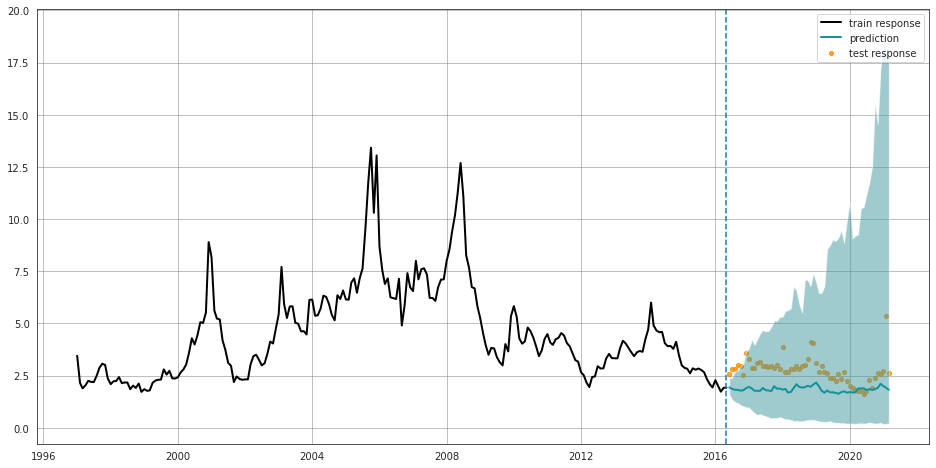

<AxesSubplot:>

In [114]:
from orbit.diagnostics.plot import plot_predicted_data

#dlt_pred_1m_exp = dlt_pred_1m.copy()

#dlt_pred_1m_exp[:, 1:]

# нужен в тесте обязательно столбец log_price
ts1_m_test['log_price'] = np.log(ts1_m_test.price)

# сделаем логарифмированные стробцы, а покажем нормальные

print('DLT Predictions')

plot_predicted_data(
    training_actual_df=ts1_m_train.apply(lambda x: np.exp(x) if x.name == 'log_price' else x), 
    predicted_df=dlt_pred_1m.apply(lambda x: np.exp(x) if x.name in ['prediction_5','prediction','prediction_95'] else x),
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=ts1_m_test.apply(lambda x: np.exp(x) if x.name == 'log_price' else x),
     insample_line=True
)

LGT Predictions


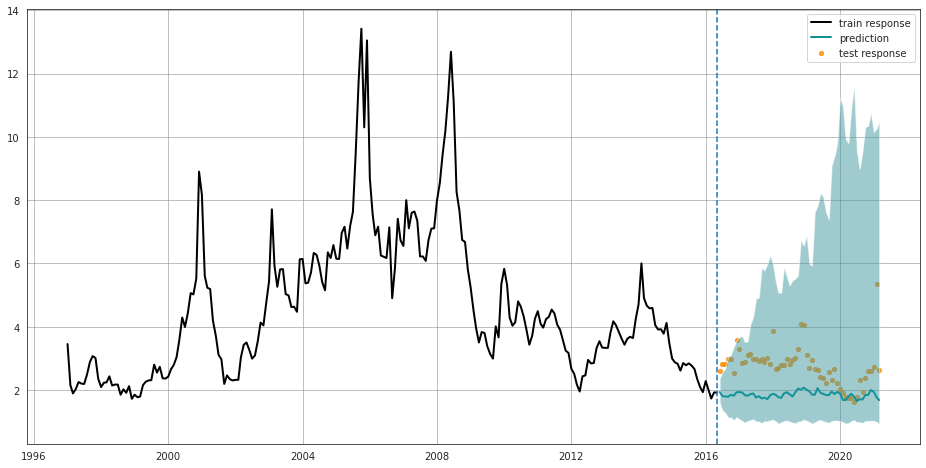

<AxesSubplot:>

In [115]:
print('LGT Predictions')

plot_predicted_data(
    training_actual_df=ts1_m_train.apply(lambda x: np.exp(x) if x.name == 'log_price' else x), 
    predicted_df=lgt_pred_1m.apply(lambda x: np.exp(x) if x.name in ['prediction_5','prediction','prediction_95'] else x),
    date_col=lgt.date_col, actual_col=lgt.response_col,
    test_actual_df=ts1_m_test.apply(lambda x: np.exp(x) if x.name == 'log_price' else x),
     insample_line=True
)

In [116]:
#ts1_m_train

### ETS (2 балла).

Обучите из библиотеки `sklearn` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [117]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# ваш код обучения моделей здесь

ets_aaa = ExponentialSmoothing(trend='add', seasonal='add', sp=12) # потому что логарифмировали
ets_aaa_pred_1m = ets_aaa.fit(ts1_m_train.log_price).predict(fh1)
mae_ets_aaa_pred_1m = meanabs(np.exp(ets_aaa_pred_1m), ts1_m_test['price'])


autoets = AutoETS(auto=True, n_jobs=-1, sp=12)
autoets_pred_1m = autoets.fit(ts1_m_train.log_price).predict(fh1)
mae_autoets_pred_1m = meanabs(np.exp(autoets_pred_1m), ts1_m_test['price'])

results.loc[8,"Frequency"] = "Monthly"
results.loc[8,"Model"] = "ETS(AAA)"
results.loc[8,"Forecast"] = "Exponential Smoothing"
results.loc[8,"MAE"] = mae_ets_aaa_pred_1m


results.loc[9,"Frequency"] = "Monthly"
results.loc[9,"Model"] = "AutoETS"
results.loc[9,"Forecast"] = "Exponential Smoothing"
results.loc[9,"MAE"] = mae_autoets_pred_1m
results[results.Frequency=='Monthly']

,Frequency,Model,Forecast,MAE
0,Monthly,Last,1.92,0.871724
2,Monthly,Previous,Previous Month,7.79998
4,Monthly,SARIMA,Seasonal Autoregression + Moving Average,0.908931
5,Monthly,AutoSARIMA,Seasonal Autoregression + Moving Average,1.01865
6,Monthly,DLT,Damped Local Trend,0.932891
7,Monthly,LGT,Local Global Trend,0.921323
8,Monthly,ETS(AAA),Exponential Smoothing,0.997915
9,Monthly,AutoETS,Exponential Smoothing,0.871724


In [118]:
# посчитайте метрики на test # посчитали выше

Лучше всего из моделей со скользящим или растущим окном показала себя `AutoETS`. Отметим, что ее качество, на удивление, совпало с самым наивным подходом -- предсказывать последнее наблюдаемое значение. Интересно сравнить графики (и оценить, насколько MAE была хорошей идеей).

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

In [119]:
# нарисуйте пресказания

# тянемся за ДИ
# face support prediction intervals, but we haven’t implemented them for all algorithms yet.
# https://www.sktime.org/en/latest/examples/01_forecasting.html#Prediction-intervals

autoets = AutoETS(auto=True, n_jobs=-1, sp=12)
#autoets_pred_1m, intervals = 
best_predictions = autoets.fit(ts1_m_train.log_price).predict(fh1)#, return_pred_int=True)#, return_pred_int=True)
autoets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:              log_price   No. Observations:                  233
Model:                       ETS(ANN)   Log Likelihood                 140.220
Date:                Sun, 13 Jun 2021   AIC                           -274.439
Time:                        18:45:19   BIC                           -264.086
Sample:                    01-31-1997   HQIC                          -270.265
                         - 05-31-2016   Scale                            0.018
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.067     14.944      0.000       0.869       1.131
initial_level       1.2383      0.136      9.087      0.000       0.971       1.505
===================================================================================
Ljung-Box (Q):                        0.90   Jarque-Bera (JB):                18.58
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [120]:
best_predictions # самый лучший прогноз, который модель смогла подобрать -- наивный, даже при подборе по AIC. 
#Ряд окзазался не по зубам втроенным алгоритмам

2016-06    0.652325
2016-07    0.652325
2016-08    0.652325
2016-09    0.652325
2016-10    0.652325
2016-11    0.652325
2016-12    0.652325
2017-01    0.652325
2017-02    0.652325
2017-03    0.652325
2017-04    0.652325
2017-05    0.652325
2017-06    0.652325
2017-07    0.652325
2017-08    0.652325
2017-09    0.652325
2017-10    0.652325
2017-11    0.652325
2017-12    0.652325
2018-01    0.652325
2018-02    0.652325
2018-03    0.652325
2018-04    0.652325
2018-05    0.652325
2018-06    0.652325
2018-07    0.652325
2018-08    0.652325
2018-09    0.652325
2018-10    0.652325
2018-11    0.652325
2018-12    0.652325
2019-01    0.652325
2019-02    0.652325
2019-03    0.652325
2019-04    0.652325
2019-05    0.652325
2019-06    0.652325
2019-07    0.652325
2019-08    0.652325
2019-09    0.652325
2019-10    0.652325
2019-11    0.652325
2019-12    0.652325
2020-01    0.652325
2020-02    0.652325
2020-03    0.652325
2020-04    0.652325
2020-05    0.652325
2020-06    0.652325
2020-07    0.652325


In [123]:
"""# нарисуйте пресказания

# тянемся за ДИ -- тянуться долго, Демешев сказал, что тогда можно не тянуться))
# face support prediction intervals, but we haven’t implemented them for all algorithms yet.
# https://www.sktime.org/en/latest/examples/01_forecasting.html#Prediction-intervals


train_ets1m = ts1_m_train.copy()
train_ets1m.index = pd.PeriodIndex(train_ets1m.index)

autoets = AutoETS(auto=True, n_jobs=-1, sp=12, full_output=True)
#autoets_pred_1m, intervals = 
autoets.fit(train_ets1m.log_price).predict(fh1_series)#, return_pred_int=True)#, return_pred_int=True)#, return_pred_int=True)
#autoets.summary()"""

'# нарисуйте пресказания\n\n# тянемся за ДИ -- тянуться долго, Демешев сказал, что тогда можно не тянуться))\n# face support prediction intervals, but we haven’t implemented them for all algorithms yet.\n# https://www.sktime.org/en/latest/examples/01_forecasting.html#Prediction-intervals\n\n\ntrain_ets1m = ts1_m_train.copy()\ntrain_ets1m.index = pd.PeriodIndex(train_ets1m.index)\n\nautoets = AutoETS(auto=True, n_jobs=-1, sp=12, full_output=True)\n#autoets_pred_1m, intervals = \nautoets.fit(train_ets1m.log_price).predict(fh1_series)#, return_pred_int=True)#, return_pred_int=True)#, return_pred_int=True)\n#autoets.summary()'

In [124]:
autoets_pred_1m.index

PeriodIndex(['2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11',
             '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05',
             '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
             '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05',
             '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11',
             '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05',
             '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11',
             '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05',
             '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11',
             '2020-12', '2021-01', '2021-02', '2021-03'],
            dtype='period[M]', freq='M')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

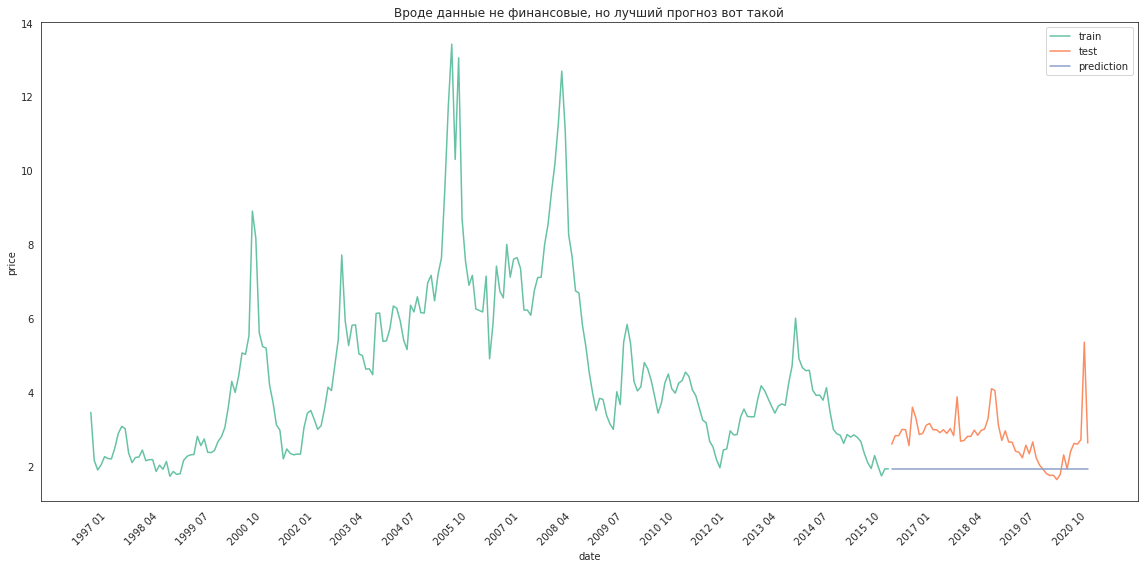

In [125]:
fig,axes=plt.subplots(1,1)
# ts1_m_test['log_price'] = np.log(ts1_m_test['price']) # тест мы не меняем, но хотим посмотреть на график
sns.lineplot(x=ts1_m_train['date'], y=ts1_m_train['price'], data=ts1_m_train, )
sns.lineplot(x=ts1_m_test['date'], y=ts1_m_test['price'], data=ts1_m_test)
sns.lineplot(x=ts1_m_test['date'], y=np.exp(autoets_pred_1m), data=autoets_pred_1m)
axes.xaxis.set_major_locator(MaxNLocator(31))
plt.xticks(rotation=45)
axes.legend(['train', 'test', 'prediction'])
plt.title('Вроде данные не финансовые, но лучший прогноз вот такой')
plt.tight_layout()

## Задание 4. Предсказание дневного временного ряда (2.5 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (0.5 балла).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [126]:
from sktime.forecasting.naive import NaiveForecaster

# ваш код обучения моделей здесь # уже сделали выше

In [127]:
# посчитайте метрики на test

Сделал выше, покажу еще раз

In [128]:
results[results.Frequency == 'Daily']

,Frequency,Model,Forecast,MAE
1,Daily,Last,99730.6,1665.97
3,Daily,Previous,That day year back,2043.12


### KTR из orbit (1 балл).



In [129]:
from orbit.models.ktrlite import KTRLiteMAP

# ваш код обучения моделей здесь

ktr = KTRLiteMAP(
    response_col='megawatts',
    date_col='date',
    # seasonality
    seasonality=[7, 365.25],
    #seasonality_fs_order=[2, 5],
    #level_knot_scale=.1,
    #span_level=.05,
    #span_coefficients=.3,
    #estimator_type=StanEstimatorMAP,
)

ktr.fit(ts2_d_train)

ktr_pred_2d = ktr.predict(ts2_d_test)

#

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_54eae5ecf2d426f33baa7b746b329122 NOW.


In [130]:
ktr_pred_2d.head()

,date,prediction_5,prediction,prediction_95
0,20180612,98507.021203,101007.993909,103492.340829
1,20180613,98535.981141,101007.335886,103474.680044
2,20180614,98480.298810,101007.327899,103460.410511
3,20180615,98559.657498,101007.969960,103550.029845
4,20180616,98491.616066,101007.673314,103495.788669


In [133]:
# посчитайте метрики на test

mae_ktr_pred_1m = meanabs(ktr_pred_2d.prediction, ts2_d_test['megawatts'])


results.loc[8,"Frequency"] = "Daily"
results.loc[8,"Model"] = "KTR"
results.loc[8,"Forecast"] = "KTR"
results.loc[8,"MAE"] = mae_ktr_pred_1m

results

,Frequency,Model,Forecast,MAE
0,Monthly,Last,1.92,0.871724
1,Daily,Last,99730.6,1665.97
2,Monthly,Previous,Previous Month,7.79998
3,Daily,Previous,That day year back,2043.12
4,Monthly,SARIMA,Seasonal Autoregression + Moving Average,0.908931
5,Monthly,AutoSARIMA,Seasonal Autoregression + Moving Average,1.01865
6,Monthly,DLT,Damped Local Trend,0.932891
7,Monthly,LGT,Local Global Trend,0.921323
8,Daily,KTR,KTR,2440.59
9,Monthly,AutoETS,Exponential Smoothing,0.871724


KTR Predictions


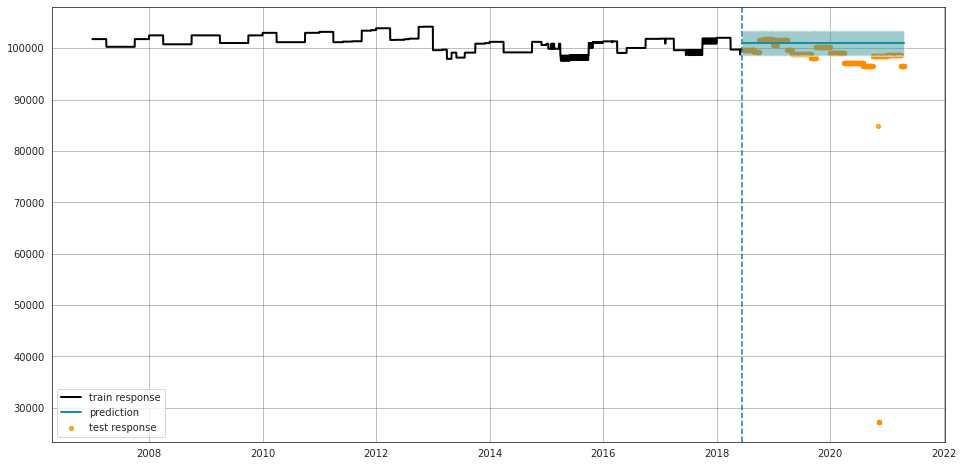

<AxesSubplot:>

In [134]:
print('KTR Predictions')

plot_predicted_data(
    training_actual_df=ts2_d_train,
    predicted_df=ktr_pred_2d, 
    date_col=ktr.date_col, actual_col=ktr.response_col,
    test_actual_df=ts2_d_test, #.apply(lambda x: np.exp(x) if x.name == 'log_price' else x),
     insample_line=True
)

In [135]:
# посчитайте метрики на test
results[results.Frequency == 'Daily']

,Frequency,Model,Forecast,MAE
1,Daily,Last,99730.6,1665.97
3,Daily,Previous,That day year back,2043.12
8,Daily,KTR,KTR,2440.59


### Phophet (1 балл).



In [136]:
from prophet import Prophet

# ваш код обучения моделей здесь

train2d_prophet = ts2_d_train.copy()
train2d_prophet.columns = ['ds', 'y']


test2d_prophet = ts2_d_test.copy()
test2d_prophet.columns = ['ds', 'y']


prophet = Prophet(interval_width=0.9)

# добавляем регрессоры
#model.add_regressor('trend.unemploy')
#model.add_regressor('trend.filling')
#model.add_regressor('trend.job')

# обучаем модель
prophet.fit(train2d_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [137]:

# делаем прогноз на указанные даты
prophet_pred_2d = prophet.predict(test2d_prophet)
prophet_pred_2d[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2018-06-12,99864.258103,99197.065815,100504.709536
1,2018-06-13,99865.628627,99209.374224,100553.828373
2,2018-06-14,99866.327522,99233.367717,100521.229771
3,2018-06-15,99850.603917,99163.410859,100509.768146
4,2018-06-16,99760.974176,99099.826674,100422.358966


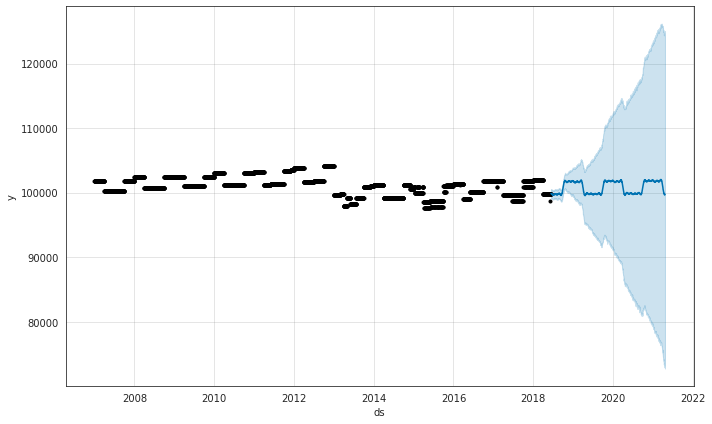

In [138]:
fig1 = prophet.plot(prophet_pred_2d)

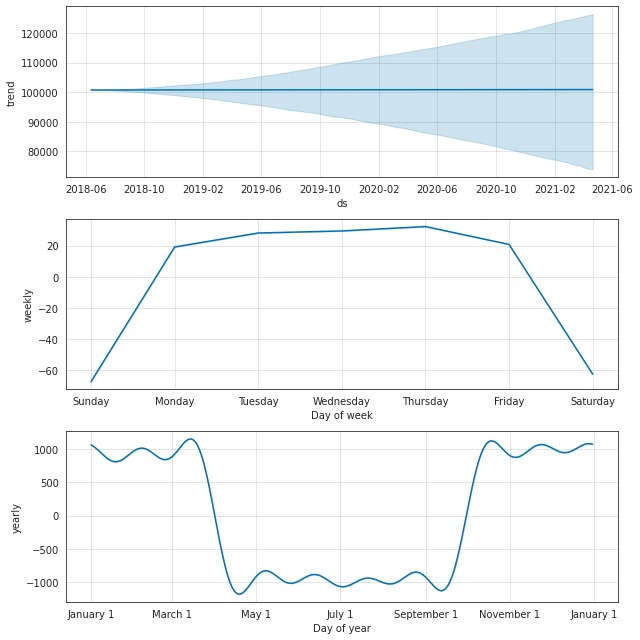

In [139]:

# даже можем вывести компоненты прогноза
fig2 = prophet.plot_components(prophet_pred_2d)

In [140]:
prophet_pred_2d.yhat.shape

(1045,)

In [141]:
# посчитайте метрики на test

mae_prophet_pred_2d = meanabs(prophet_pred_2d.yhat, ts2_d_test['megawatts'])

results.loc[9,"Frequency"] = "Daily"
results.loc[9,"Model"] = "Prophet"
results.loc[9,"Forecast"] = "Facebook's BlackBox"
results.loc[9,"MAE"] = mae_lgt_pred_1m
results[results.Frequency == 'Daily']

,Frequency,Model,Forecast,MAE
1,Daily,Last,99730.6,1665.97
3,Daily,Previous,That day year back,2043.12
8,Daily,KTR,KTR,2440.59
9,Daily,Prophet,Facebook's BlackBox,0.921323


`Prophet` всех обошел.

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

Prophet Predictions


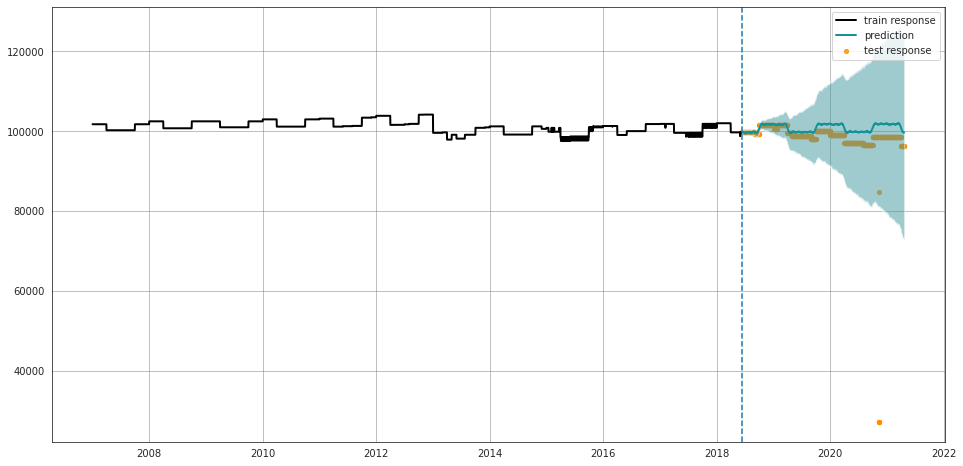

<AxesSubplot:>

In [142]:
# нарисуйте пресказания

# переименуем для графика от Орбита

prophet_pred_2d_forOrbitpolt = prophet_pred_2d[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]
prophet_pred_2d_forOrbitpolt.columns = lgt_pred_1m.columns

print('Prophet Predictions')

plot_predicted_data(
    training_actual_df=ts2_d_train,
    predicted_df=prophet_pred_2d_forOrbitpolt, 
    date_col=ktr.date_col, actual_col=ktr.response_col,
    test_actual_df=ts2_d_test, #.apply(lambda x: np.exp(x) if x.name == 'log_price' else x),
     insample_line=True
)

In [143]:
#lgt_pred_1m.columns, prophet_pred_2d.columns

In [144]:
prophet_pred_2d.yhat.shape, ts2_d_test['date'].shape

((1045,), (1045,))

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

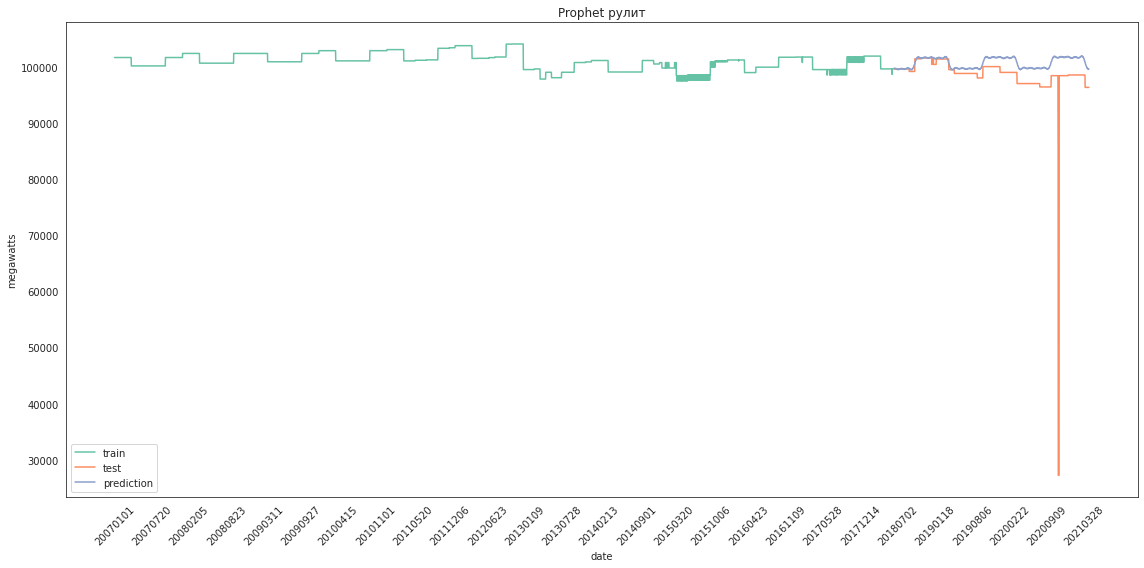

In [145]:
fig,axes=plt.subplots(1,1)
# ts1_m_test['log_price'] = np.log(ts1_m_test['price']) # тест мы не меняем, но хотим посмотреть на график
sns.lineplot(x=ts2_d_train['date'], y=ts2_d_train['megawatts'], data=ts2_d_train, )
sns.lineplot(x=ts2_d_test['date'], y=ts2_d_test['megawatts'], data=ts2_d_test)
sns.lineplot(x=ts2_d_test['date'], y=np.array(prophet_pred_2d.yhat), data=ts2_d_test)
axes.xaxis.set_major_locator(MaxNLocator(31))
plt.xticks(rotation=45)
axes.legend(['train', 'test','prediction'])
plt.title('Prophet рулит')
plt.tight_layout()

In [146]:
#np.array(prophet_pred_2d.yhat)

## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытай свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной на тестовой выборке с помощью MAE. 



In [147]:
# ваш код модели на STAN и её обучения моделей здесь

In [148]:
# посчитайте метрики на test

In [149]:
# нарисуйте пресказания